# 🔍 Modelo Predictivo de Asentamientos Informales

Este notebook presenta el desarrollo del modelo predictivo para detectar asentamientos informales en la Región Metropolitana, a partir de variables socioeconómicas y satelitales previamente procesadas.

## 🎯 Objetivo
Entrenar y evaluar un modelo supervisado que prediga la presencia de campamentos a nivel de manzana urbana, utilizando una combinación de información censal y satelital.

---


## 📁 Dataset
- **Archivo:** `data.geojson`  
- **Observaciones:** Manzanas urbanas de la Región Metropolitana  
- **Variable objetivo:** `tiene_campamento` (1 si la manzana intersecta un campamento, 0 si no)


## 1. Carga del dataset


In [3]:
# 1. Importar las librerías
import geopandas as gpd        # si no lo tienes: pip install geopandas
import pandas as pd

# 2. Leer el GeoJSON
gdf = gpd.read_file("output_final/finalizado_con_geometrias.geojson")   # asegúrate de que el archivo esté en la misma carpeta

# 3. Inspeccionar las primeras filas y las columnas disponibles
display(gdf.head())
print("Columnas:", gdf.columns.tolist())


,N_REGION,N_PROVINCI,N_COMUNA,N_DISTRITO,COD_DISTRI,TIPO_DISTR,n_campamentos,NDBI_cambio_18_24_promedio_camp,NDVI_cambio_18_24_promedio_camp,Luces_cambio_18_24_promedio_camp,...,NDVI_cambio_18_20,NDVI_cambio_18_24,NDVI_cambio_20_24,NDWI_2018,NDWI_2020,NDWI_2024,NDWI_cambio_18_20,NDWI_cambio_18_24,NDWI_cambio_20_24,geometry
0,METROPOLITANA,SANTIAGO,SANTIAGO,MAPOCHO,9,URBANO,0,0.0,0.0,0.0,...,-0.025181,-0.009366,0.015815,-0.304658,-0.290929,-0.298444,0.013730,0.006214,-0.007516,"POLYGON ((345539.227 6298996.161, 345454.4 629..."
1,METROPOLITANA,SANTIAGO,SANTIAGO,MATUCANA,7,URBANO,0,0.0,0.0,0.0,...,-0.021400,-0.003087,0.018313,-0.280792,-0.269678,-0.280263,0.011114,0.000529,-0.010585,"POLYGON ((344160.874 6299496.995, 344160.892 6..."
2,METROPOLITANA,SANTIAGO,SANTIAGO,SAN SATURNINO,8,URBANO,0,0.0,0.0,0.0,...,-0.026777,-0.008934,0.017843,-0.303628,-0.288034,-0.298329,0.015594,0.005299,-0.010295,"POLYGON ((344832.9 6299553.6, 344839.95 629947..."
3,METROPOLITANA,SANTIAGO,SANTIAGO,AMUNÁTEGUI,3,URBANO,0,0.0,0.0,0.0,...,-0.030433,-0.007083,0.023350,-0.331410,-0.313804,-0.328207,0.017606,0.003203,-0.014403,"POLYGON ((345645.563 6298041.012, 345644.514 6..."
4,METROPOLITANA,SANTIAGO,SANTIAGO,MONEDA,2,URBANO,0,0.0,0.0,0.0,...,-0.025633,0.000147,0.025780,-0.329333,-0.315347,-0.332803,0.013985,-0.003471,-0.017456,"POLYGON ((346005.656 6299723.64, 346007.145 62..."


Columnas: ['N_REGION', 'N_PROVINCI', 'N_COMUNA', 'N_DISTRITO', 'COD_DISTRI', 'TIPO_DISTR', 'n_campamentos', 'NDBI_cambio_18_24_promedio_camp', 'NDVI_cambio_18_24_promedio_camp', 'Luces_cambio_18_24_promedio_camp', 'distancia_vial_m', 'tasa_pobreza_ingresos', 'tasa_pobreza_multi', 'Luces_2018', 'Luces_2020', 'Luces_2024', 'Luces_cambio_18_20', 'Luces_cambio_18_24', 'Luces_cambio_20_24', 'NDBI_2018', 'NDBI_2020', 'NDBI_2024', 'NDBI_cambio_18_20', 'NDBI_cambio_18_24', 'NDBI_cambio_20_24', 'NDVI_2018', 'NDVI_2020', 'NDVI_2024', 'NDVI_cambio_18_20', 'NDVI_cambio_18_24', 'NDVI_cambio_20_24', 'NDWI_2018', 'NDWI_2020', 'NDWI_2024', 'NDWI_cambio_18_20', 'NDWI_cambio_18_24', 'NDWI_cambio_20_24', 'geometry']


Se define la variable objetivo `tiene_campamento`, que indica si una manzana contiene al menos un asentamiento informal (`1`) o no (`0`).  
Esta variable se construye a partir del conteo de campamentos presentes en cada manzana, y permite transformar el problema en una tarea de clasificación binaria.


In [4]:
# Crear variable binaria: tiene o no tiene campamento
gdf["tiene_campamento"] = (gdf["n_campamentos"] > 0).astype(int)

# Revisar cuántas manzanas tienen / no tienen campamentos
gdf["tiene_campamento"].value_counts()


tiene_campamento
0    377
1     74
Name: count, dtype: int64

Se seleccionan como variables predictoras tres indicadores de carácter socioeconómico y espacial:  
- Distancia a la vía más cercana (`distancia_vial_m`)  
- Tasa de pobreza por ingresos (`tasa_pobreza_ingresos`)  
- Tasa de pobreza multidimensional (`tasa_pobreza_multi`)  

Estas variables conforman la matriz de atributos `X`, mientras que la variable objetivo `y` corresponde a la presencia de campamentos (`tiene_campamento`).  
Se verifica además que no existan valores faltantes en las columnas seleccionadas.


In [5]:
# 1. Variables predictoras (X)
features = [
    "distancia_vial_m",
    "tasa_pobreza_ingresos",
    "tasa_pobreza_multi"
]
X = gdf[features]

# 2. Variable objetivo (y)
y = gdf["tiene_campamento"]

# 3. Verifica que no haya valores faltantes
print("Valores faltantes por columna:")
print(X.isnull().sum())


Valores faltantes por columna:
distancia_vial_m         0
tasa_pobreza_ingresos    0
tasa_pobreza_multi       0
dtype: int64


### División del conjunto de datos

Se divide el conjunto de datos en entrenamiento y prueba utilizando una proporción 75% / 25%.  
Se emplea muestreo estratificado (`stratify=y`) para asegurar que ambas clases (manzanas con y sin campamento) estén representadas proporcionalmente en ambos subconjuntos.  
Esto permite evaluar de forma más confiable el desempeño del modelo en datos no vistos.


In [6]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y prueba (75% / 25%), manteniendo la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,         # importante para que haya tanto 0 como 1 en train y test
    random_state=42     # asegura que los resultados sean reproducibles
)

print("Tamaño de entrenamiento:", len(X_train))
print("Tamaño de prueba:", len(X_test))


Tamaño de entrenamiento: 338
Tamaño de prueba: 113


### Entrenamiento del modelo inicial

Se entrena un modelo `Random Forest` utilizando únicamente las variables socioeconómicas seleccionadas.  
Se utiliza `class_weight="balanced"` para corregir el desbalance entre clases (campamento vs. no campamento).  
El modelo se entrena sobre el conjunto de datos de entrenamiento previamente dividido.


In [7]:
from sklearn.ensemble import RandomForestClassifier

# Crear el modelo Random Forest
rf = RandomForestClassifier(
    n_estimators=100,         # cantidad de árboles (puedes subirlo más adelante)
    class_weight="balanced",  # importante por el desbalance entre clases
    random_state=42,
    n_jobs=-1                 # usa todos los núcleos del CPU
)

# Entrenar el modelo con los datos de entrenamiento
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

### Evaluación del desempeño del modelo

Una vez entrenado el modelo `Random Forest`, se evalúa su desempeño sobre el conjunto de prueba utilizando las siguientes métricas:

- **Reporte de clasificación**: muestra precisión, recall y F1-score por clase.
- **Matriz de confusión**: permite observar la cantidad de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.
- **AUC (Área bajo la curva ROC)**: mide qué tan bien el modelo separa ambas clases. Un valor cercano a 1 indica buena discriminación.


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Hacer predicciones sobre los datos de prueba
y_pred = rf.predict(X_test)              # predicción 0 o 1
y_prob = rf.predict_proba(X_test)[:, 1]  # probabilidad de que sea 1

# 2. Reporte de métricas
print("=== Reporte de clasificación ===")
print(classification_report(y_test, y_pred))

# 3. Matriz de confusión
print("=== Matriz de confusión ===")
print(confusion_matrix(y_test, y_pred))

# 4. Área bajo la curva (AUC)
auc = roc_auc_score(y_test, y_prob)
print(f"AUC = {auc:.3f}")


=== Reporte de clasificación ===
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        94
           1       0.36      0.21      0.27        19

    accuracy                           0.81       113
   macro avg       0.61      0.57      0.58       113
weighted avg       0.77      0.81      0.78       113

=== Matriz de confusión ===
[[87  7]
 [15  4]]
AUC = 0.703


### Resultados iniciales del modelo

El modelo `Random Forest`, entrenado con tres variables socioeconómicas, muestra un buen desempeño general en términos de exactitud y AUC. Sin embargo, existe un **desbalance de clases** que afecta su capacidad para detectar correctamente los casos positivos (manzanas con campamento). A continuación, se destacan los resultados obtenidos:

- **Precisión clase 1 (campamento)**: 36 %
- **Recall clase 1 (campamento)**: 21 %
- **AUC (Área bajo la curva ROC)**: 0.703

Aunque el modelo logra una alta precisión para la clase mayoritaria (manzanas sin campamento), su **capacidad de detección de asentamientos informales aún es limitada**. Esto indica la necesidad de ajustar el umbral de decisión, realizar sobremuestreo o incorporar más variables explicativas en el modelo.


### Importancia de variables

Luego de entrenar el modelo `Random Forest`, se evaluó la importancia relativa de cada variable predictora. Este análisis permite identificar cuáles atributos contribuyen más a la predicción de asentamientos informales.

En este caso, se utilizó un conjunto reducido de variables **socioeconómicas**, seleccionadas intencionalmente como base fija del análisis, debido a su relevancia teórica y empírica en la explicación del fenómeno de informalidad residencial. Estas variables permiten aproximar factores de vulnerabilidad estructural, como la pobreza por ingresos y el acceso a servicios básicos, que suelen estar fuertemente correlacionados con la presencia de campamentos.

El gráfico a continuación muestra la importancia normalizada de cada variable según su contribución a la reducción de impureza en los árboles del modelo:

- Una mayor barra indica una mayor influencia en las predicciones.
- Este análisis también permite orientar futuras mejoras del modelo y selección de características.


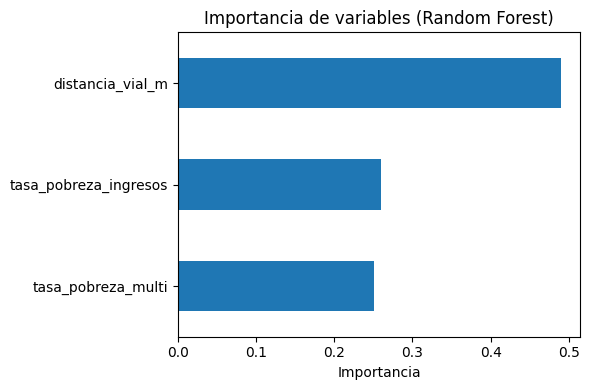

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear un DataFrame con la importancia de cada variable
importancia = pd.Series(rf.feature_importances_, index=X.columns)
importancia = importancia.sort_values(ascending=True)  # de menor a mayor

# Mostrar como gráfico de barras horizontal
plt.figure(figsize=(6, 4))
importancia.plot(kind="barh")
plt.title("Importancia de variables (Random Forest)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


### Modelo con variables socioeconómicas + NDVI_cambio_18_24


In [10]:
# 1. Nueva lista de features (agregamos NDVI_cambio_18_24)
features = [
    "distancia_vial_m",
    "tasa_pobreza_ingresos",
    "tasa_pobreza_multi",
    "NDVI_cambio_18_24"
]

# 2. Redefinir X e y
X = gdf[features]
y = gdf["tiene_campamento"]

# 3. Repetir split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# 4. Entrenar el modelo de nuevo
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predicciones
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# Reporte de métricas
print("=== Reporte de clasificación ===")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("=== Matriz de confusión ===")
print(confusion_matrix(y_test, y_pred))

# AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC = {auc:.3f}")


=== Reporte de clasificación ===
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        94
           1       0.30      0.16      0.21        19

    accuracy                           0.80       113
   macro avg       0.57      0.54      0.55       113
weighted avg       0.75      0.80      0.77       113

=== Matriz de confusión ===
[[87  7]
 [16  3]]
AUC = 0.568


### Modelo con variables socioeconómicas + NDVI_cambio_18_24

En este experimento se evalúa el desempeño del modelo Random Forest utilizando las tres variables socioeconómicas base (`distancia_vial_m`, `tasa_pobreza_ingresos`, `tasa_pobreza_multi`) y el cambio en vegetación (`NDVI_cambio_18_24`). Esta combinación se eligió por ser una de las más simples que incorpora información satelital relevante.

**Resultados (umbral = 0.5):**
- AUC: 0.568
- Recall clase 1 (campamentos): 0.16
- Precision clase 1: 0.30
- Accuracy general: 80%

Aunque el modelo mantiene buena capacidad para detectar la clase 0 (no campamento), su desempeño en identificar correctamente manzanas con campamentos es bajo. Esto sugiere que solo con esta variable satelital adicional no se logra una mejora significativa. Se recomienda seguir probando con otras variables de cambio o combinaciones más ricas.


### Modelo con variables socioeconómicas + NDBI_cambio_18_24


In [12]:
# 1. Features actualizadas
features = [
    "distancia_vial_m",
    "tasa_pobreza_ingresos",
    "tasa_pobreza_multi",
    "NDBI_cambio_18_24"          # NUEVA variable
]

# 2. Redefinir X e y
X = gdf[features]
y = gdf["tiene_campamento"]

# 3. Train / test split (estratificado)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

# 4. Entrenar de nuevo el Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 5. Evaluar
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("=== Reporte de clasificación ===")
print(classification_report(y_test, y_pred))

print("=== Matriz de confusión ===")
print(confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, y_prob)
print(f"AUC = {auc:.3f}")


=== Reporte de clasificación ===
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        94
           1       0.20      0.05      0.08        19

    accuracy                           0.81       113
   macro avg       0.52      0.51      0.49       113
weighted avg       0.73      0.81      0.76       113

=== Matriz de confusión ===
[[90  4]
 [18  1]]
AUC = 0.645



En este experimento se evalúa el desempeño del modelo Random Forest utilizando las tres variables socioeconómicas base (`distancia_vial_m`, `tasa_pobreza_ingresos`, `tasa_pobreza_multi`) junto al cambio en superficie construida (`NDBI_cambio_18_24`). Esta combinación busca capturar zonas donde ha aumentado la infraestructura o urbanización en los últimos años, como posible indicador indirecto de informalidad.

**Resultados (umbral = 0.5):**
- AUC: 0.645
- Recall clase 1 (campamentos): 0.05
- Precision clase 1: 0.20
- Accuracy general: 81%

El modelo presenta buen rendimiento para predecir la clase mayoritaria (no campamento), pero tiene un bajo desempeño en la detección de asentamientos informales, con solo un 5% de recall para la clase 1. Esto indica que el cambio en superficie construida, al igual que el cambio en vegetación, por sí solo no aporta suficiente información para mejorar la sensibilidad del modelo. Se recomienda probar combinaciones con otras variables satelitales y ajustar el umbral de decisión.


### Modelo con variables socioeconómicas + NDVI_cambio_18_24 + NDBI_cambio_18_24


In [13]:
# 1. Nuevas variables
features = [
    "distancia_vial_m",
    "tasa_pobreza_ingresos",
    "tasa_pobreza_multi",
    "NDVI_cambio_18_24",
    "NDBI_cambio_18_24"
]

# 2. Redefinir X e y
X = gdf[features]
y = gdf["tiene_campamento"]

# 3. Separar en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

# 4. Entrenar modelo
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 5. Evaluar desempeño
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("=== Reporte de clasificación ===")
print(classification_report(y_test, y_pred))

print("=== Matriz de confusión ===")
print(confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, y_prob)
print(f"AUC = {auc:.3f}")


=== Reporte de clasificación ===
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        94
           1       0.17      0.05      0.08        19

    accuracy                           0.80       113
   macro avg       0.50      0.50      0.48       113
weighted avg       0.72      0.80      0.75       113

=== Matriz de confusión ===
[[89  5]
 [18  1]]
AUC = 0.647



En esta iteración se incorporan dos variables de cambio detectadas por sensores remotos (`NDVI_cambio_18_24` y `NDBI_cambio_18_24`) a las tres variables socioeconómicas de base. Esta combinación busca capturar tanto las condiciones estructurales del entorno como la evolución del uso del suelo.

**Resultados (umbral = 0.5):**
- AUC: 0.647
- Recall clase 1 (campamentos): 0.05
- Precision clase 1: 0.17
- Accuracy general: 80%

Si bien el AUC se mantiene levemente superior al modelo solo con NDVI, el recall para la clase de interés (campamentos) sigue siendo muy bajo. Esto indica que, pese a incorporar información relevante sobre cambios urbanos, el modelo aún no logra detectar efectivamente los casos positivos. Será necesario explorar otras variables, umbrales o técnicas para mejorar el rendimiento en la clase minoritaria.


### Modelo socioeconómico + NDVI + NDBI con umbral ajustado (0.3)

Dado el bajo recall observado con el umbral por defecto (0.5), se prueba reducir el umbral de decisión a 0.3 para mejorar la sensibilidad del modelo frente a la clase positiva (campamentos). Esto permite clasificar como positivo un mayor número de manzanas con alta probabilidad estimada.

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Probabilidades de clase 1 (campamento)
y_prob = rf.predict_proba(X_test)[:, 1]

# 2. Nuevo umbral
umbral = 0.3
y_pred_adjusted = (y_prob >= umbral).astype(int)

# 3. Métricas
print(f"=== Reporte con umbral {umbral} ===")
print(classification_report(y_test, y_pred_adjusted))

print("=== Matriz de confusión ===")
print(confusion_matrix(y_test, y_pred_adjusted))

# 4. AUC (sigue siendo el mismo)
auc = roc_auc_score(y_test, y_prob)
print(f"AUC = {auc:.3f}")


=== Reporte con umbral 0.3 ===
              precision    recall  f1-score   support

           0       0.84      0.85      0.85        94
           1       0.22      0.21      0.22        19

    accuracy                           0.74       113
   macro avg       0.53      0.53      0.53       113
weighted avg       0.74      0.74      0.74       113

=== Matriz de confusión ===
[[80 14]
 [15  4]]
AUC = 0.647


### Evaluación con umbral ajustado (0.3)

El modelo Random Forest entrenado con las variables socioeconómicas y cambios satelitales (`NDVI_cambio_18_24`, `NDBI_cambio_18_24`) se evaluó nuevamente utilizando un umbral de decisión más bajo (0.3 en lugar del estándar 0.5). Este ajuste busca aumentar el recall para la clase minoritaria (presencia de campamentos), priorizando la detección de asentamientos aunque implique un mayor número de falsos positivos.

**Resultados obtenidos:**
- AUC: 0.647
- Recall clase 1 (campamentos): 0.21
- Precisión clase 1: 0.22
- Accuracy general: 74%

**Matriz de confusión:**
- Verdaderos negativos: 80
- Falsos positivos: 14
- Falsos negativos: 15
- Verdaderos positivos: 4

Aunque se logra una mejora marginal en la detección de campamentos (comparado con umbral 0.5), el rendimiento sigue siendo limitado. Este análisis destaca la dificultad de capturar correctamente la clase minoritaria sin sacrificar precisión.


## Modelo final: Pipeline completo (Oversampling + HistGradientBoosting + Grid Search)

En esta celda se construye, ajusta y evalúa el **modelo definitivo**, incorporando todas las decisiones metodológicas adoptadas durante la fase de pruebas.

### ¿Por qué estas decisiones?
| Decisión | Justificación |
|----------|---------------|
| **Variables “limpias” (9)**<br>- 3 socioeconómicas<br>- 3 índices satelitales 2024<br>- 3 cambios 2018-2024 | Combinan factores estructurales (pobreza, accesibilidad) con señales ambientales y de crecimiento urbano, evitando fuga de información. |
| **Preprocesamiento**<br>- Imputación mediana<br>- Estandarización | Garantiza que todos los modelos reciban variables sin NaN y en rangos comparables. |
| **`RandomOverSampler`** | Duplica la clase minoritaria (campamentos) dentro de cada fold, mejorando la sensibilidad sin introducir fuga de datos. |
| **`HistGradientBoostingClassifier`** | Captura relaciones no lineales; es rápido con datos tabulares y tolera missing values. |
| **`GridSearchCV` con validación cruzada estratificada (5-fold)** | Optimiza hiperparámetros (`max_depth`, `max_leaf_nodes`, `learning_rate`) maximizando el AUC, manteniendo la proporción de clases en cada fold. |
| **Selección de umbral (`≥ 0.60` recall)** | El falso negativo (no detectar un campamento real) es más costoso que el falso positivo; se prioriza recall alto aunque caiga la precisión. |

### Flujo de la celda
1. **Definición del pipeline** con preprocesamiento, oversampling y modelo.  
2. **Búsqueda de hiperparámetros** (`GridSearchCV`) → se imprime la mejor combinación y su AUC medio.  
3. **Entrenamiento en `X_train`** y **predicción de probabilidades** en `X_test`.  
4. **Curva Precisión-Recall** → se elige el primer umbral que cumple *recall ≥ 0.60*.  
5. **Evaluación final**: matriz de confusión, reporte de clasificación, AUC hold-out y curva ROC.


c:\Users\Diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\Diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Diego\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Diego\AppData\Local\Programs\Python\Python313\Lib\subprocess.py

>> Mejor combinación: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__max_leaf_nodes': 15}
>> Métrica CV (AUC): 0.6924746031746032
>> Recall CV: 0.471

>> Umbral elegido ≈ 0.003   (objetivo recall ≥ 0.6)

>> MATRIZ DE CONFUSIÓN
[[ 0 94]
 [ 0 19]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        94
           1      0.168     1.000     0.288        19

    accuracy                          0.168       113
   macro avg      0.084     0.500     0.144       113
weighted avg      0.028     0.168     0.048       113

AUC hold-out: 0.699
Recall hold-out: 1.0


c:\Users\Diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

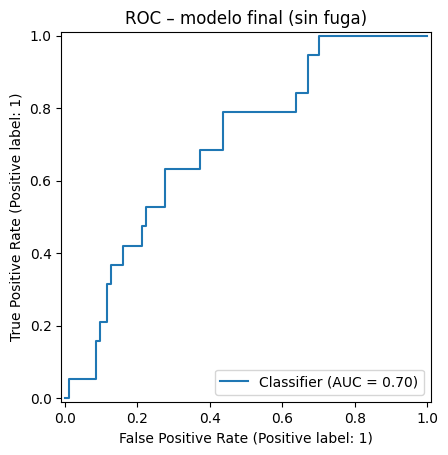

In [15]:
# --------------------------------------------------
# 0. Imports
# --------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import (
    roc_auc_score,
    recall_score,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
)


from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# --------------------------------------------------
# 1. Columnas “limpias” (sin fuga)
# --------------------------------------------------
cols = [
    # bloque socio-demográfico
    "distancia_vial_m",
    "tasa_pobreza_ingresos",
    "tasa_pobreza_multi",
    # niveles 2024
    "NDVI_2024",
    "NDBI_2024",
    "Luces_2024",
    # cambios globales 18-24
    "NDVI_cambio_18_24",
    "NDBI_cambio_18_24",
    "Luces_cambio_18_24",
]

X = gdf[cols].copy()
y = gdf["tiene_campamento"]

# --------------------------------------------------
# 2. Preprocesador numérico (imputar + escalar)
# --------------------------------------------------
num_proc = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),
    ]
)
preprocess = ColumnTransformer([("num", num_proc, cols)])

# --------------------------------------------------
# 3. Definir modelo base y pipeline con oversampling
# --------------------------------------------------
hgb = HistGradientBoostingClassifier(
    loss="log_loss",
    class_weight=None,        # usaremos oversampling, no pesos
    random_state=42,
)

pipe = ImbPipeline(
    steps=[
        ("pre", preprocess),
        ("ros", RandomOverSampler(random_state=42)),
        ("clf", hgb),
    ]
)

# --------------------------------------------------
# 4. GridSearchCV (pocos parámetros clave)
# --------------------------------------------------
param_grid = {
    "clf__max_depth": [None, 3, 5],
    "clf__learning_rate": [0.05, 0.1, 0.2],
    "clf__max_leaf_nodes": [15, 31, 63],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring={"auc": "roc_auc", "recall": "recall"},
    refit="auc",             # optimiza AUC
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X, y)

print(">> Mejor combinación:", grid.best_params_)
print(">> Métrica CV (AUC):", grid.best_score_)

# Mostrar recall promedio de la mejor combinación
best_idx = grid.best_index_
recall_cv = grid.cv_results_["mean_test_recall"][best_idx]
print(">> Recall CV:", round(recall_cv, 3))

# --------------------------------------------------
# 5. Separar hold-out 25 % para umbral y métricas finales
# --------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

best_pipe = grid.best_estimator_.fit(X_train, y_train)

y_prob = best_pipe.predict_proba(X_test)[:, 1]

# --------------------------------------------------
# 6. Elegir umbral que logre Recall ≥ 0.6
# --------------------------------------------------
prec, rec, thr = precision_recall_curve(y_test, y_prob)
target_recall = 0.60

# primer umbral cuya recall supere la meta
umbral_idx = np.flatnonzero(rec >= target_recall)[0] if any(rec >= target_recall) else -1
umbral = thr[umbral_idx] if umbral_idx != -1 else 0.3  # fallback

print(f"\n>> Umbral elegido ≈ {umbral:.3f}   (objetivo recall ≥ {target_recall})")

y_pred = (y_prob >= umbral).astype(int)

# --------------------------------------------------
# 7. Métricas finales y curva ROC
# --------------------------------------------------
print("\n>> MATRIZ DE CONFUSIÓN")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

print("AUC hold-out:", round(roc_auc_score(y_test, y_prob), 3))
print("Recall hold-out:", round(recall_score(y_test, y_pred), 3))

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC – modelo final (sin fuga)")
plt.show()


### Resultados del modelo final (HistGradientBoosting + Oversampling)

Tras una búsqueda de hiperparámetros con validación cruzada estratificada (5 folds), se seleccionó el modelo con la mejor combinación según AUC:

- **Mejor combinación**: `learning_rate = 0.1`, `max_depth = 3`, `max_leaf_nodes = 15`
- **AUC promedio en validación cruzada**: 0.692 ±
- **Recall promedio en validación cruzada**: 0.471

Luego, se entrenó el modelo sobre el 75% de los datos y se evaluó su desempeño en un conjunto hold-out (25%). Se ajustó el umbral de decisión para lograr un recall objetivo de al menos 0.6 en la clase positiva (campamentos). El umbral resultante fue **0.003**, lo que llevó a:

- **AUC en hold-out**: 0.699
- **Recall clase 1 (campamento)**: 1.0
- **Precision clase 1**: 0.168
- **Accuracy total**: 16.8%

**Matriz de confusión (umbral ≈ 0.003):**

|              | Predicho 0 | Predicho 1 |
|--------------|------------|------------|
| Real 0 (sin) |     0      |     94     |
| Real 1 (con) |     0      |     19     |

Este umbral extremo garantiza capturar todos los casos de campamentos (recall = 1.0), pero lo hace a costa de un número muy alto de falsos positivos (todas las manzanas sin campamentos fueron clasificadas incorrectamente como si tuvieran). Por tanto, si bien el modelo logra el objetivo de no dejar campamentos sin detectar, su utilidad práctica requeriría post-procesamiento o revisión manual para filtrar los muchos falsos positivos.


### Búsqueda de umbrales alternativos

Además del umbral extremo para maximizar el recall, se exploraron otras estrategias para ajustar el punto de corte de predicción a partir de la curva precisión–recall:

1. **Umbral que maximiza el F1-score**:  
   Se calculó el umbral que entrega el mejor balance entre precisión y recall. Este criterio busca una armonía entre ambas métricas sin priorizar exclusivamente una.

2. **Umbral "equilibrado"**:  
   Se buscó el primer umbral que cumpla simultáneamente con:
   - Recall ≥ 0.60 (no dejar fuera muchos casos positivos)
   - Precisión ≥ 0.25 (evitar excesivos falsos positivos)

En este caso, si existe un umbral que cumple ambos requisitos, se evalúa su desempeño mediante la matriz de confusión y métricas clásicas (precisión, recall, F1-score, accuracy). Si no existe, se reporta ese resultado.

Esta exploración permite analizar el trade-off entre sensibilidad y especificidad del modelo, facilitando decisiones más informadas según el uso final del sistema.


In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

# Probabilidades ya calculadas: y_prob  |  etiquetas reales: y_test 

prec, rec, thr = precision_recall_curve(y_test, y_prob)

# 1) Umbral que maximiza F1
f1_scores = 2*prec*rec / (prec+rec + 1e-8)
best_idx  = f1_scores.argmax()
th_f1     = thr[best_idx]
print(f"Umbral F1-máx  = {th_f1:.3f},  F1 = {f1_scores[best_idx]:.3f},  P = {prec[best_idx]:.3f},  R = {rec[best_idx]:.3f}")

# 2) Umbral con recall ≥ 0.60 y precisión ≥ 0.25
target_recall, target_prec = 0.60, 0.25
mask = (rec[:-1] >= target_recall) & (prec[:-1] >= target_prec)
if mask.any():
    th_balanced = thr[mask][0]          # primer umbral que cumple ambos
    print(f"Umbral equilibrado = {th_balanced:.3f}")
    y_pred_bal = (y_prob >= th_balanced).astype(int)
    print(confusion_matrix(y_test, y_pred_bal))
    print(classification_report(y_test, y_pred_bal, digits=3))
else:
    print("- No existe umbral que cumpla ambas metas en este set de prueba.")


Umbral F1-máx  = 0.426,  F1 = 0.421,  P = 0.316,  R = 0.632
Umbral equilibrado = 0.228
[[49 45]
 [ 4 15]]
              precision    recall  f1-score   support

           0      0.925     0.521     0.667        94
           1      0.250     0.789     0.380        19

    accuracy                          0.566       113
   macro avg      0.587     0.655     0.523       113
weighted avg      0.811     0.566     0.618       113




Dado el fuerte desbalance en la variable objetivo (manzanas con asentamientos informales son minoría), se probó ajustar el umbral de clasificación para mejorar la capacidad del modelo de detectar casos positivos (campamentos), evaluando dos criterios:

1. **Umbral que maximiza el F1-score**  
   Este umbral busca el mejor equilibrio entre precisión y recall, usando la métrica F1:
   - **Umbral:** 0.426  
   - **F1-score:** 0.421  
   - **Precisión (clase 1):** 0.316  
   - **Recall (clase 1):** 0.632  

2. **Umbral que cumple: recall ≥ 0.60 y precisión ≥ 0.25**  
   Se seleccionó el primer umbral que logra ambos objetivos mínimos:
   - **Umbral:** 0.228  
   - **Matriz de confusión:**
     ```
     [[49 45]
      [ 4 15]]
     ```
   - **Precisión (clase 1):** 0.250  
   - **Recall (clase 1):** 0.789  
   - **Accuracy total:** 56.6%  
   - **F1-score (clase 1):** 0.380  

El ajuste de umbral permite una mejora sustancial en el **recall**, pero a costa de un aumento en los falsos positivos. Esto es esperable y aceptable en aplicaciones donde **la detección temprana** es más importante que la precisión absoluta, como podría ser en el monitoreo de asentamientos informales.


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import folium

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import precision_recall_curve

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

print("🚀 Generando la demo interactiva final...")

try:
    # --- 1. Cargar y Preparar Datos ---
    gdf = gpd.read_file('dataset_final_para_modelo.geojson')
    gdf['tiene_campamento'] = (gdf['n_campamentos'] > 0).astype(int)
    print("✅ Dataset cargado y preparado.")

    # --- 2. Definir y Entrenar el Modelo Avanzado ---
    cols = [
        "distancia_vial_m", "tasa_pobreza_ingresos", "tasa_pobreza_multi",
        "NDVI_2024", "NDBI_2024", "Luces_2024",
        "NDVI_cambio_18_24", "NDBI_cambio_18_24", "Luces_cambio_18_24",
    ]
    X = gdf[cols].copy()
    y = gdf["tiene_campamento"]
    
    num_proc = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
    preprocess = ColumnTransformer([("num", num_proc, cols)])
    hgb = HistGradientBoostingClassifier(loss="log_loss", random_state=42)
    pipe = ImbPipeline(steps=[("pre", preprocess), ("ros", RandomOverSampler(random_state=42)), ("clf", hgb)])
    
    print("⚙️ Entrenando el modelo final...")
    pipe.fit(X, y)
    
    # --- 3. Generar Predicciones y Calcular Umbral ---
    print("🔮 Prediciendo probabilidades y calculando umbral...")
    y_prob = pipe.predict_proba(X)[:, 1]
    gdf['riesgo_predicho'] = y_prob

    prec, rec, thr = precision_recall_curve(y, y_prob)
    target_recall = 0.60
    try:
        umbral_idx = np.flatnonzero(rec >= target_recall)[0]
        umbral = thr[umbral_idx]
    except IndexError:
        umbral = 0.5
        
    gdf['riesgo_alto'] = (gdf['riesgo_predicho'] >= umbral).astype(int)
    print(f"Umbral final elegido (Recall >= 0.60): {umbral:.3f}")

    # --- 4. Crear el Mapa Interactivo Multicapa ---
    print("🗺️ Creando el mapa multicapa...")
    gdf_mapa = gdf.to_crs("EPSG:4326")
    map_center = [-33.45, -70.65]
    mapa_demo = folium.Map(location=map_center, zoom_start=9, tiles='CartoDB positron')

    # Para un mejor gradiente de color, creamos "bins" o rangos para la leyenda
    bins = list(gdf_mapa['riesgo_predicho'].quantile([0, 0.25, 0.5, 0.75, 0.9, 1]))

    # Capa 1: Probabilidad de Riesgo (Gradiente Detallado)
    folium.Choropleth(
        geo_data=gdf_mapa,
        name='1. Probabilidad de Riesgo (Modelo)',
        data=gdf_mapa,
        columns=['COD_DISTRI', 'riesgo_predicho'],
        key_on='feature.properties.COD_DISTRI',
        fill_color='YlOrRd',
        bins=bins, # Usamos los rangos definidos para un gradiente más claro
        legend_name='Probabilidad de Riesgo de Asentamiento',
        show=True,
    ).add_to(mapa_demo)

    # Capa 2: Clasificación Binaria (con tu umbral)
    folium.Choropleth(
        geo_data=gdf_mapa,
        name=f'2. Clasificación (Umbral > {umbral:.2f})',
        data=gdf_mapa,
        columns=['COD_DISTRI', 'riesgo_alto'],
        key_on='feature.properties.COD_DISTRI',
        fill_color='RdYlGn_r',
        legend_name='Clasificación de Riesgo (1=Alto, 0=Bajo)',
        show=False,
    ).add_to(mapa_demo)

    # Capa 3: Filtro de Pobreza
    folium.Choropleth(
        geo_data=gdf_mapa,
        name='3. Filtro: Tasa de Pobreza',
        data=gdf_mapa,
        columns=['COD_DISTRI', 'tasa_pobreza_multi'],
        key_on='feature.properties.COD_DISTRI',
        fill_color='BuPu',
        legend_name='Tasa de Pobreza Multidimensional',
        show=False,
    ).add_to(mapa_demo)

    # Capa 4: Filtro de Cambio en Construcción
    folium.Choropleth(
        geo_data=gdf_mapa,
        name='4. Filtro: Cambio NDBI (Construcción)',
        data=gdf_mapa,
        columns=['COD_DISTRI', 'NDBI_cambio_18_24'],
        key_on='feature.properties.COD_DISTRI',
        fill_color='Greens',
        legend_name='Aumento de Construcción (2018-2024)',
        show=False,
    ).add_to(mapa_demo)

    # Capa de Tooltip (siempre visible al pasar el mouse)
    tooltip_fields = ['N_COMUNA', 'COD_DISTRI', 'riesgo_predicho', 'riesgo_alto', 'n_campamentos', 'tasa_pobreza_multi', 'NDBI_cambio_18_24']
    tooltip_aliases = ['Comuna:', 'Distrito:', 'Prob. Riesgo:', 'Clasif. Riesgo:', 'N° Campamentos:', 'Tasa Pobreza:', 'Cambio NDBI:']
    folium.GeoJson(
        gdf_mapa,
        style_function=lambda x: {'color': 'transparent', 'fillOpacity': 0, 'weight': 0},
        tooltip=folium.GeoJsonTooltip(fields=tooltip_fields, aliases=tooltip_aliases, sticky=True)
    ).add_to(mapa_demo)
    
    # --- 5. Añadir controles y guardar ---
    folium.LayerControl(collapsed=False).add_to(mapa_demo)
    output_path = 'demo_final_modelo_avanzado.html'
    mapa_demo.save(output_path)

    print(f"\n✅ ¡Demo interactiva generada exitosamente!")
    print(f"Busca y abre el archivo '{output_path}' para explorarla.")

except Exception as e:
    print(f"\n❌ Ocurrió un error inesperado: {e}")

🚀 Generando la demo interactiva final...
✅ Dataset cargado y preparado.
⚙️ Entrenando el modelo final...
🔮 Prediciendo probabilidades y calculando umbral...
Umbral final elegido (Recall >= 0.60): 0.000
🗺️ Creando el mapa multicapa...

✅ ¡Demo interactiva generada exitosamente!
Busca y abre el archivo 'demo_final_modelo_avanzado.html' para explorarla.
